In [47]:
### for 80mpc box
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.interpolate as interp
import scipy as sp
import re



global1 =[]
global2 =[]
global3 = []
def unPackRawFile(raw_path):
    """
    - unpacks the Raw conditions file. Not used for the neural network.
    """
    y = np.loadtxt(raw_path, skiprows=6)
    distance = y[:,0]
    pec_vel = y[:,1]
    temp = y[:,2]
    HI_density = y[:,3]
    gas_density = y[:,4]
    gas_metallicity = y[:,5]
    
    return distance, pec_vel, temp, HI_density, gas_density, gas_metallicity
    
def unPackRawFlux(flux_path):
    """
    - unpacks the Raw conditions file. Not used for the neural network.
    """
    y2 = np.genfromtxt(flux_path, skip_header=1, delimiter=' , ')
    velocity = y2[:,0]
    flux = y2[:,1] 
    return velocity, flux
def hubble_flow_convert(velocity, a, omega_m, omega_lam):
    """
    - uses hubble flow to convert from velocity to distance
    """
    aH = a * 100 * (omega_m / a ** 3 + omega_lam)** 0.5
    return velocity/aH
def resample(distance, item, new_distance):
    """
    - interpolates the distances so that we can resample. useful because the velocity after converting using hubble flow doesn't have the same positions as the underlying properties.
    - creates a consistent distance scale (obviously these distances are messed up by peculiar velocities)
    """
    f = interp.interp1d(distance, item)
    new_item = f(new_distance)
    
    return new_item
def getDir(path_LOS,linenumber=7):
    """
    the direction of the LOS is given inside each file, (in the comments)
    this function parses the comments to get that information
    """
    f = open(path_LOS)
    x = f.readlines()[linenumber]
    answer = re.search('\(([^)]+)', x.split(', ')[1]).group(1)
    arr = np.array(answer.split(','),dtype=float)
    return arr
def getPos(path_LOS,linenumber=7):
    """
    the start position of the LOS is given inside each file, (in the comments)
    this function parses the comments to get that information
    """
    f = open(path_LOS)
    x = f.readlines()[linenumber]
    answer = re.search('\(([^)]+)', x).group(1)
    arr = np.array(answer.split(','),dtype=float)
    return arr
def convertSphereToCart(theta, phi):
    "converts a unit vector in spherical to cartesian, needed for getGalaxies"
    return np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])

def get_galaxies(gals, path_LOS, number,Lbox = 80,aexp = 0.1452):
    """
    function can take in the path of the galaxy file (.res) and the line of sight. Number should match the LOS #
    """   
    # Parameter
    #Lbox = 80  # box size
    #aexp = 0.1452  # scale factor for the epoch
    OmegaM = 0.3036
    h100 = 0.6814    # normalized Hubble constant
    pos = np.array(getPos(path_LOS))  # origin of LOS
    pos = pos/512*80
    sphere_los = np.array(getDir(path_LOS))  # direction of LOS , np.sum(e3**2) should be = 1
    e3 = convertSphereToCart(sphere_los[0], sphere_los[1])
    Mvir = gals[0] # SFR
    xg = gals[1] #\
    yg = gals[2] # | positions of the galaxies in cMpc/h
    zg = gals[3] #/
    vx = gals[4] #\
    vy = gals[5] # | velocities of the galaxies in km/s
    vz = gals[6] #/
    
    out_arr = Box(Lbox, OmegaM, h100, aexp, Mvir, xg, yg, zg, vx, vy, vz, pos, e3)
    num_arr = number*np.ones(len(out_arr.T))
    return np.vstack([out_arr, num_arr])
def Box(Lbox, OmegaM, h100, aexp, Mvir, xg, yg, zg, vx, vy, vz, pos, e3):
    """
    Wraps LOS to the original box (0-80), helper function for get galaxies.
    """
    ##### find intersection between LOS and grid
    planeNormal = np.array([[1, 0, 0],[0, 1, 0],[0, 0, 1]])
    if e3[0] > 0:
        planePoint_x = np.array([[80, 0, 0],[160, 0, 0],[240, 0, 0]])
        planePoint_x_inverse = np.array([0,0,0])
    else:
        planePoint_x = np.array([[0, 0, 0],[-80, 0, 0],[-120, 0, 0]])
        planePoint_x_inverse = np.array([80,0,0])
    if e3[1] > 0:
        planePoint_y = np.array([[0, 80, 0],[0, 160, 0],[0, 240, 0]])
        planePoint_y_inverse = np.array([0,0,0])
    else:
        planePoint_y = np.array([[0, 0, 0],[0, -80, 0],[0, -160, 0]])
        planePoint_y_inverse = np.array([0,80,0])
    if e3[2] > 0:
        planePoint_z = np.array([[0, 0, 80],[0, 0, 160],[0, 0, 240]])
        planePoint_z_inverse = np.array([0,0,0])
    else:
        planePoint_z = np.array([[0, 0, 0],[0, 0, -80],[0, 0, -160]])
        planePoint_z_inverse = np.array([0,0,80])
    
    planePoint = np.vstack((planePoint_x,planePoint_y,planePoint_z))
    intercept_pts = LinePlaneIntersection(planeNormal=planeNormal, planePoint=planePoint, losDirection=e3, losPoint=pos)
    intercept_pts[:,0][0:3] = planePoint_x[:,0]
    intercept_pts[:,1][3:6] = planePoint_y[:,1]
    intercept_pts[:,2][6:] = planePoint_z[:,2]
    planePoint_inverse = np.vstack((planePoint_x_inverse,planePoint_y_inverse,planePoint_z_inverse))
    intercept_pts_inverse = LinePlaneIntersection(planeNormal=planeNormal, planePoint=planePoint_inverse, losDirection=(-1)*e3, losPoint=pos)
    for i in range(3):
        intercept_pts_inverse[i,i] = planePoint_inverse[i,i]
    los_start_pts_inverse = np.where(np.logical_and(e3>0, intercept_pts_inverse == 0), 80, intercept_pts_inverse)
    distance_inverse = (-1)*np.sqrt(np.sum((intercept_pts_inverse-pos)**2,axis=1))
    distance = np.sqrt(np.sum((intercept_pts-pos)**2,axis=1))
    new_los_start_pts = np.vstack((pos,intercept_pts[distance<270]%80))
    new_los_start_pts = np.where(np.logical_and(e3<0, new_los_start_pts == 0), 80, new_los_start_pts)
    new_los_start_pts = np.vstack((new_los_start_pts,los_start_pts_inverse))
    x = xg
    y = yg
    z = zg
    new_x = np.tile(x, (len(new_los_start_pts), 1))
    new_y = np.tile(y, (len(new_los_start_pts), 1))
    new_z = np.tile(z, (len(new_los_start_pts), 1))
    w = e3[0]*(new_x-new_los_start_pts[:,0][:, np.newaxis])+\
        e3[1]*(new_y-new_los_start_pts[:,1][:, np.newaxis])+\
        e3[2]*(new_z-new_los_start_pts[:,2][:, np.newaxis])
    dx = new_x - new_los_start_pts[:,0][:, np.newaxis] - w*e3[0]
    dy = new_y - new_los_start_pts[:,1][:, np.newaxis] - w*e3[1]
    dz = new_z - new_los_start_pts[:,2][:, np.newaxis] - w*e3[2]
    new_x = np.where(dx>40,new_x-80,new_x)
    new_x = np.where(dx<-40,new_x+80,new_x)
    new_y = np.where(dy>40,new_y-80,new_y)
    new_y = np.where(dy<-40,new_y+80,new_y)
    new_z = np.where(dz>40,new_z-80,new_z)
    new_z = np.where(dz<-40,new_z+80,new_z)
    w = e3[0]*(new_x-new_los_start_pts[:,0][:, np.newaxis])+\
        e3[1]*(new_y-new_los_start_pts[:,1][:, np.newaxis])+\
        e3[2]*(new_z-new_los_start_pts[:,2][:, np.newaxis])
    dx = new_x - new_los_start_pts[:,0][:, np.newaxis] - w*e3[0]
    dy = new_y - new_los_start_pts[:,1][:, np.newaxis] - w*e3[1]
    dz = new_z - new_los_start_pts[:,2][:, np.newaxis] - w*e3[2]
    distance_all = np.concatenate((np.insert(distance[distance<270],0,0),distance_inverse))[:, np.newaxis]
    w += distance_all
    # distance from the galaxy to the LOS
    dr = np.sqrt(dx**2+dy**2+dz**2)
    # convert w from real to redshift space
    aH = 100*aexp*np.sqrt(OmegaM/aexp**3+(1-OmegaM))
    w += (e3[0]*vx+e3[1]*vy+e3[2]*vz)/aH
    # convert dr from comoving Mpc/h to proper Mpc
    dr *= (aexp/h100)
    Mvir = np.tile(Mvir, (len(new_los_start_pts), 1))
    # select galaxies
    sel1 = np.logical_and(w>5,w<195) # within first 200 cMpc/h
    sel2 = np.logical_and(dr<.1,Mvir>10**8)
    sel = np.logical_and(sel1,sel2)
    if(len(sel) > 0):
        Mvir1 = Mvir[sel]
        w1 = w[sel]
        w1 = np.round(w1,decimals=8)
        dr1 = dr[sel]
        dr1 = np.round(dr1,decimals=8)
        global1.append(dx[sel])
        global2.append(dy[sel])
        global3.append(dz[sel])
        #gives Mvir, distance along LOS, and distance away from LOS
        #why have unique
        return np.array([Mvir1,w1,dr1])
    else:
        return np.array([[],[],[]])
def LinePlaneIntersection(planeNormal, planePoint, losDirection, losPoint):
    """
    Finds the intersection between LOS and grid
    This function does a lot of floating point arithmetic
    so the intersection at x=0 may be at x=-1e16, for example
    I correct the result in Box() because intersection at 0 means the LOS starting pt is 80
    """
    ndotu = planeNormal.dot(losDirection)
    w = losPoint - planePoint
    si = np.array([-planeNormal[i].dot(w[i*len(w)//3:(i+1)*len(w)//3].T) / ndotu[i] for i in [0,1,2]])
    Psi = w + np.vstack(np.multiply.outer(si,losDirection)) + planePoint
    return Psi
def get_LOS_distance_zspace(path_LOS, aexp, OmegaM, new_distance):
    """
    Distance along LOS is in real space. Needs to use peculiar velocity in .raw file to convert to redshift space.
    new_distance is in real space (where data is sampled)
    """
    distance, pec_vel, temp, HI_density, gas_density, gas_metallicity = unPackRawFile(path_LOS)
    aH = 100*aexp*np.sqrt(OmegaM/aexp**3+(1-OmegaM))
    x_redshift_space = distance + pec_vel/aH
    f = interp.interp1d(distance, x_redshift_space)
    new_distance_redshift_space = f(new_distance)
    
    return new_distance_redshift_space


In [48]:
#galaxy Mvir, x,y,z, vx, vy, vz
gals = np.loadtxt('hprops.res', usecols=[0,5,6,7],unpack=1) 
# setting vx, vy, vz to be 0, so the position is in real space, to match the v=0 LOS
gals_vel = np.zeros((3,gals.shape[1]))
gals = np.concatenate((gals,gals_vel))

In [49]:
LOS_num = 2

los_gal_list = []
for i in np.arange(0,LOS_num):
        #pulling data from galaxies
    flux_path = 'los.00' + '{0:03}'.format(i) +'.raw'
    
    los_gal_data = get_galaxies(gals, flux_path, i, Lbox = 80,aexp = 0.1452)
      
    los_gal_list.append(los_gal_data)

In [85]:

total = 0
for i in range(100):
    total += len(global1[i])
total

98203

In [99]:
import pickle

In [1]:
with open('a_results_3_dr=0.1_m=8.pkl', 'rb') as f:
    data = pickle.load(f)

NameError: name 'pickle' is not defined

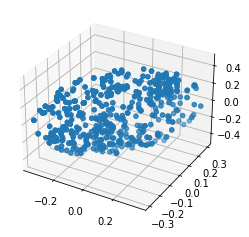

In [ ]:
ax = plt.axes(projection='3d')
##x,y,z
ax.scatter3D(global1, global2, global3)

In [ ]:
los_location = getDir('los.00' + '{0:03}'.format(1) +'.raw')
cartesian  = convertSphereToCart(los_location[0], los_location[1])
cartesian

array([ 0.54203995, -0.24738173,  0.80311579])

In [ ]:
##data is:gives sfr, distance along LOS, and distance away from LOS
#I am just going to simply look at distance vs sfr right here, any thing within 2 chimp away form the lls is counted as a galaxy associated with it
def associated_sphere(all_distance,data,counts):
    """
    this function finds every galaxy associated with lls in a sphere radius. However, it might double count 
    """
    ##going through every los
    associated = []
    for i in range(counts):
        ##going through the lls in the los
        for k in all_distance[i]:
            ##calculating the distance of every galaxy's relationship with lls
            for z in range(len(data[i][1])):
                if(np.square((k-data[i][1][z])**2 + (data[i][2][z]/0.1452*0.68)**2) <.1):
                    ##mass, distance along, distance away, distance from lls.
                    associated.append([global1[i][z],global2[i][z]])
    return associated

In [ ]:
def associated_cylinder(left, right,data,counts):
    """
    this function finds every galaxy associated with lls in a cylinder, which the length is defined by the lls left base and right base
    """
    associated = []
    for i in range(counts):
        for k,d in zip(left[i],right[i]):
            for z in range(len(data[i][1])):
                if(k < data[i][1][z] and data[i][1][z]< d):
                    associated.append([global1[i][z],global2[i][z],data[i][0][z]])
                    if(data[i][0][z] > 1e10):
                        print(i,k,d,data[i][0][z])
    return associated

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.interpolate as interp
import scipy as sp
import re
def unPackRawFile(raw_path):
    """
    - unpacks the Raw conditions file. Not used for the neural network.
    """
    y = np.loadtxt(raw_path, skiprows=6)
    distance = y[:,0]
    pec_vel = y[:,1]
    temp = y[:,2]
    HI_density = y[:,3]
    gas_density = y[:,4]
    gas_metallicity = y[:,5]
    
    return distance, pec_vel, temp, HI_density, gas_density, gas_metallicity

In [ ]:
def lyman_identification():
    """
    function for identifying lls using neutral fraction as filter
    """
    neutral_fraction_limit = 1e-3
    data = []
    l_bases = []
    r_bases = []
    for i in range(100):
        raw_path = 'los.00' + '{0:03}'.format(i) +'.raw'
        distance, pec_vel, temp, HI_density, gas_density, gas_metallicity = unPackRawFile(raw_path)
        #changing the distance from chimp to cmeters
        distance_cm = distance *0.1474*3.086e24 /0.68
        temp_data =[]
        temp_left =[]
        temp_right = []
        for k in range(len(distance) -2):
            if(HI_density[k]/gas_density[k]<neutral_fraction_limit and HI_density[k+1]/gas_density[k+1]>neutral_fraction_limit):
                left_bases = k
                peak_fraction = HI_density[k]/gas_density[k]
                peak_HI = HI_density[k]
                peak_distance = distance[k]
                if( k+1 <len(distance)):
                    while(not(HI_density[k]/gas_density[k]>neutral_fraction_limit and HI_density[k+1]/gas_density[k+1]<neutral_fraction_limit) and k <len(distance)-1):
                        right_bases = k
                        if(k<len(distance)-1):
                            k+=1
                        if(HI_density[k]/gas_density[k]>peak_fraction):
                            peak_fraction = HI_density[k]/gas_density[k]
                            peak_HI = HI_density[k]
                            peak_distance = distance[k]
                    area_under = peak_HI *1/2*(distance_cm[right_bases]-distance_cm[left_bases])/0.937415
                    if(area_under >= (1.6*10**17)and area_under  <= (10**20)):
                        temp_data.append(peak_distance)
                        temp_left.append(distance[left_bases])
                        temp_right.append(distance[right_bases])
        data.append(temp_data)
        l_bases.append(temp_left)
        r_bases.append(temp_right)
    return data,l_bases,r_bases
lyman_limited_value,left_bases,right_bases = lyman_identification()


In [ ]:
with open('lyman_limited_value.pkl', 'wb') as f:
    pickle.dump(lyman_limited_value, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('left_bases.pkl', 'wb') as f:
    pickle.dump(left_bases, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('right_bases.pkl', 'wb') as f:
    pickle.dump(right_bases, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('local.pkl', 'wb') as f:
    pickle.dump(los_gal_list, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('x_galaxies.pkl', 'wb') as f:
    pickle.dump(global1, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('y_galaxies.pkl', 'wb') as f:
    pickle.dump(global2, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
max

[[0.35315136476426795, 57.28296, 9],
 [0.4266666666666667, 37.33814, 39],
 [0.3996451803666469, 148.957, 49],
 [0.3523459581684567, 13.61089, 52],
 [0.3630462724935733, 105.93955, 74],
 [0.3619439868204284, 57.24244, 78],
 [0.3989880404783809, 146.99662, 82]]

In [ ]:
right_bases[1]

[87.8793, 113.82429, 118.65219]

In [ ]:
difference = []
difference = np.subtract(right_bases[1],left_bases[1])
difference[2]

0.02562000000000353

In [ ]:
len(data)

1000

In [ ]:
len(right_bases)

1000

In [ ]:
lyman_limited_value

[[],
 [87.84425, 113.82144, 118.64769],
 [1.65065, 9.67578, 107.77678, 152.64549, 180.40597],
 [],
 [91.80602, 91.9904, 98.3885, 139.49486, 142.48364],
 [199.37549],
 [112.06471],
 [30.50207],
 [83.89149],
 [37.43754, 57.28296, 64.52623],
 [75.57014, 149.49602],
 [76.90389, 76.92432, 153.89842],
 [69.09768],
 [112.20401],
 [68.04368, 125.74195],
 [],
 [],
 [9.61785, 49.00331, 60.16239, 148.06541, 162.47516],
 [],
 [27.9702, 46.008],
 [80.24754, 195.76871],
 [72.20163, 183.64926],
 [],
 [58.2624, 106.76067],
 [91.59354, 192.2876],
 [41.3124, 95.5038],
 [36.42391, 138.48497],
 [51.51792, 73.1247, 129.14918, 177.73873],
 [31.14512, 113.04517],
 [62.98574],
 [],
 [132.36985, 151.15249, 164.38514],
 [61.32596, 82.81558, 152.65397, 181.1316],
 [68.88616, 89.6211],
 [],
 [60.92242, 67.48151],
 [113.17714, 179.14092],
 [24.01868, 46.51339],
 [3.63946],
 [37.33814, 189.69211],
 [],
 [128.10924, 155.5047],
 [197.64519],
 [23.09426, 47.20109, 97.2684],
 [164.70967],
 [79.53648],
 [138.66533],
 []

In [ ]:
associated = associated_cylinder(left_bases,right_bases,los_gal_list,100)

4 91.98248 92.01278 11850000000.0
4 91.98248 92.01278 11850000000.0
11 153.87317 153.91324 41360000000.0
11 153.87317 153.91324 13160000000.0
11 153.87317 153.91324 41360000000.0
11 153.87317 153.91324 13160000000.0
14 125.72581 125.75353 10090000000.0
20 80.23967 80.24754 27730000000.0
26 36.38874 36.43474 15860000000.0
26 36.38874 36.43474 15860000000.0
26 36.38874 36.43474 15860000000.0
26 36.38874 36.43474 15860000000.0
41 155.48417 155.5264 45670000000.0
41 155.48417 155.5264 45670000000.0
49 148.93812 148.96886 12740000000.0
60 18.55384 18.59307 11990000000.0
60 18.55384 18.59307 11990000000.0
60 18.55384 18.59307 11990000000.0
60 18.55384 18.59307 11990000000.0
60 18.55384 18.59307 11990000000.0
78 57.23158 57.24668 58550000000.0
78 57.23158 57.24668 58550000000.0
78 57.23158 57.24668 58550000000.0
87 37.12365 37.15214 16060000000.0
87 37.12365 37.15214 16060000000.0
87 37.12365 37.15214 16060000000.0
89 118.6185 118.64277 15980000000.0


In [ ]:
max = 0
count = 0
for i in range(100):
    neutral_fraction = []
    raw_path = 'los.00' + '{0:03}'.format(i) +'.raw'
    distance, pec_vel, temp, HI_density, gas_density, gas_metallicity = unPackRawFile(raw_path)
    neutral_fraction = np.divide(HI_density,gas_density)
    for k in neutral_fraction:
        if k > max:
            max = k
            count = i
max
count 

17

(57.23158, 57.24668)

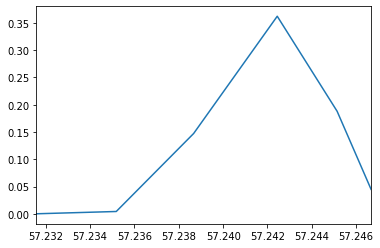

In [ ]:
raw_path = 'los.00' + '{0:03}'.format(78) +'.raw'
distance, pec_vel, temp, HI_density, gas_density, gas_metallicity = unPackRawFile(raw_path)
plt.plot(distance,HI_density/gas_density)
plt.xlim(57.23158, 57.24668 )

(153.87317, 153.91324)

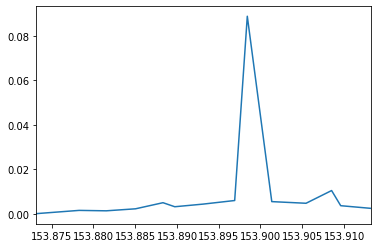

In [ ]:
raw_path = 'los.00' + '{0:03}'.format(11) +'.raw'
distance, pec_vel, temp, HI_density, gas_density, gas_metallicity = unPackRawFile(raw_path)
plt.plot(distance,HI_density/gas_density)
plt.xlim(153.87317, 153.91324)

(155.48417, 155.5264)

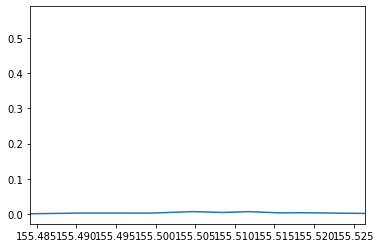

In [ ]:
raw_path = 'los.00' + '{0:03}'.format(41) +'.raw'
distance, pec_vel, temp, HI_density, gas_density, gas_metallicity = unPackRawFile(raw_path)
plt.plot(distance,HI_density/gas_density)
plt.xlim(155.48417 ,155.5264 )

Text(0.5, 1.0, 'dy vs dx in associated galaxies, and color map using mass of the galaxies')

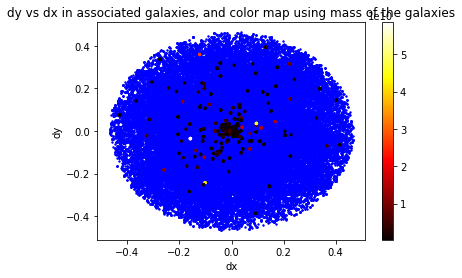

In [ ]:
for i,k in zip(global1,global2):
    plt.scatter(i,k,color = "blue",s = 2)

x =[]
y =[]
mass = []
for i in associated:
    x.append(i[0])
    y.append(i[1])
    mass.append(i[2])
plt.scatter(x,y,c = mass,cmap="hot",s = 6)
plt.colorbar()
plt.xlabel("dx")
plt.ylabel("dy")
plt.title("dy vs dx in associated galaxies, and color map using mass of the galaxies")

##the largest galaxy is associated with one of the highest neutral faction value in the lls.

##the two most massive associated galaxies are both associated with one of the highest neutral fraction lls.

In [ ]:
max_mass = []
for i in mass:
    if 1e10 < i:
        max_mass.append(i)
max_mass

[11850000000.0,
 11850000000.0,
 41360000000.0,
 13160000000.0,
 41360000000.0,
 13160000000.0,
 10090000000.0,
 27730000000.0,
 15860000000.0,
 15860000000.0,
 15860000000.0,
 15860000000.0,
 45670000000.0,
 45670000000.0,
 12740000000.0,
 11990000000.0,
 11990000000.0,
 11990000000.0,
 11990000000.0,
 11990000000.0,
 58550000000.0,
 58550000000.0,
 58550000000.0,
 16060000000.0,
 16060000000.0,
 16060000000.0,
 15980000000.0]

In [ ]:
associated2 = associated_sphere(lyman_limited_value,los_gal_list,100)

In [ ]:
len(associated2)

5584

Text(0, 0.5, 'dy')

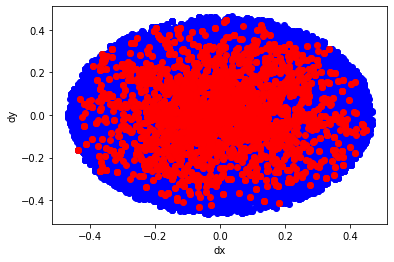

In [ ]:
for i,k in zip(global1,global2):
    plt.scatter(i,k,color = "blue")

for i in associated2:
    plt.scatter(i[0],i[1],color = "red")
plt.xlabel("dx")
plt.ylabel("dy")

In [ ]:
lyman_limited_value[1]

[87.84425, 113.82144, 118.64769]

In [ ]:
np.multiply(lyman_limited_value[1],cartesian[0])

array([47.61509302, 61.69576784, 64.31178815])

[ 0.54203995 -0.24738173  0.80311579]


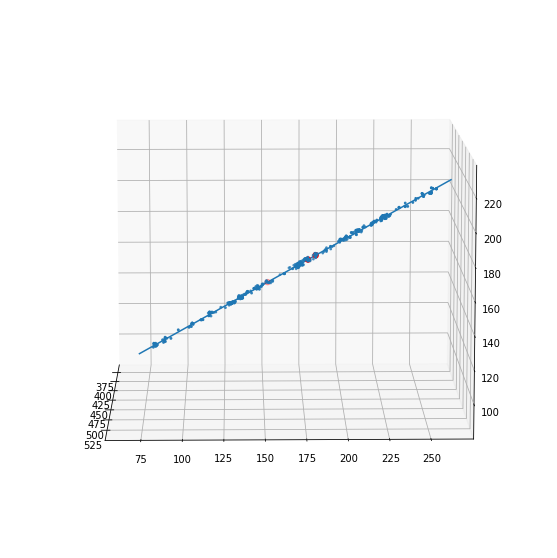

In [ ]:
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection = '3d')
start = [365.286,67.6426,89.7729]
print(cartesian)
end = [start[0]+200*np.cos(cartesian[0]), start[1]+200*np.cos(cartesian[1]),start[2]+200*np.cos(cartesian[2])]
x = [start[0],end[0]]
y = [start[1],end[1]]
z = [start[2],end[2]]
plt.plot(x,y,z)
ax.scatter(start[0]+los_gal_list[1][1]*np.cos(cartesian[0]) +global1[2]/0.1452*0.68, start[1]+los_gal_list[1][1]*np.cos(cartesian[1]) +global2[2]/0.1452*0.68,start[2]+los_gal_list[1][1]*np.cos(cartesian[2])+ +global3[2]/0.1452*0.68,s = 3)
ax.scatter(start[0]+np.multiply(lyman_limited_value[1],np.cos(cartesian[0])), start[1]+np.multiply(lyman_limited_value[1],np.cos(cartesian[1])),start[2]+np.multiply(lyman_limited_value[1],np.cos(cartesian[2])),s =30,c="red")
for ii in range(0,360,1):
    ax.view_init(elev=10., azim=ii)
    plt.savefig("movie%d.png" % ii)

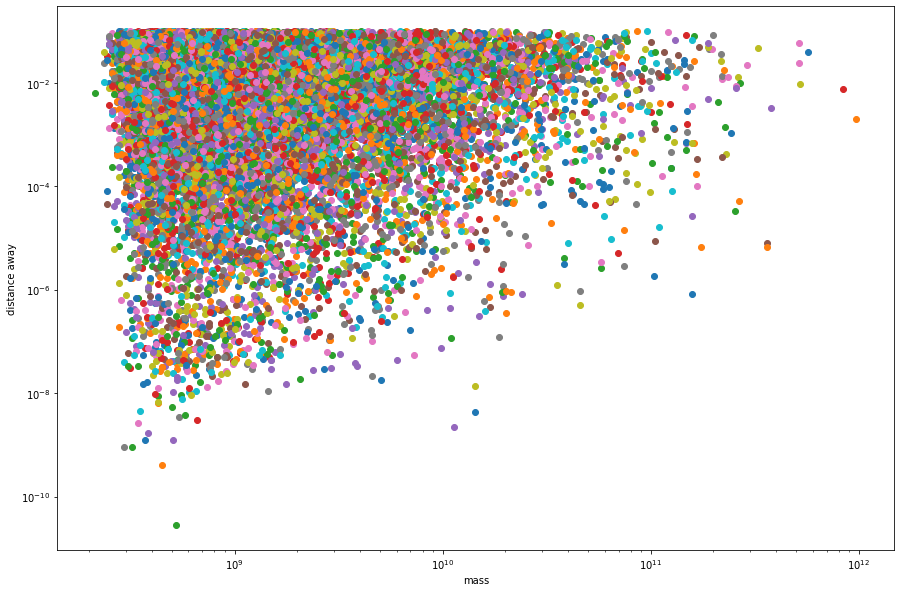

In [ ]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111) 
ax.set_xlabel("mass")
ax.set_ylabel("distance away")    
ax.set_xscale("log")
ax.set_yscale("log")
for i in range (len(associated)):
    ax.scatter(associated[i][2],associated[i][5])
plt.show()

In [ ]:
len(associated)

28985

28985


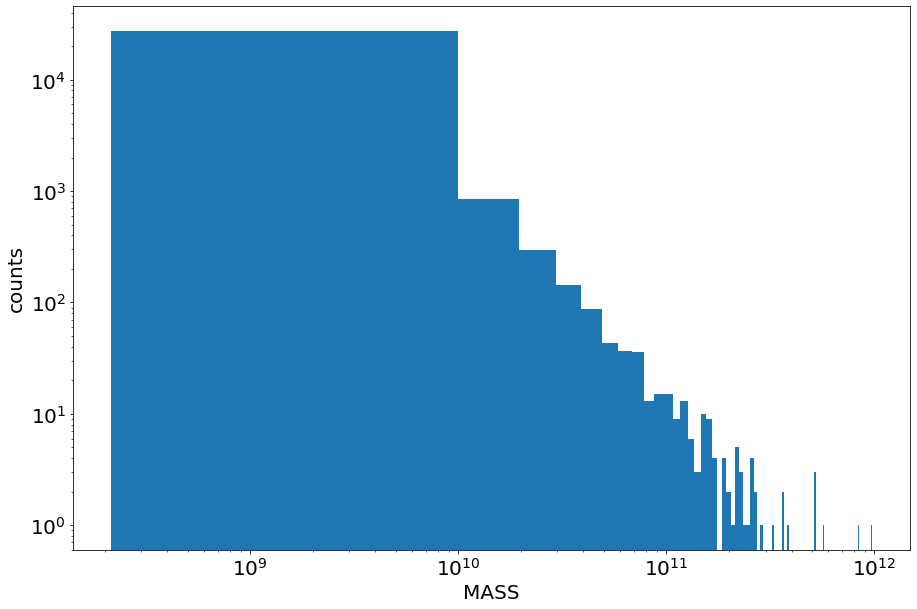

In [ ]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111) 
mass_data = []
count = 0
for i in range(len(associated)):
        mass_data.append(associated[i][2])
        count +=1
ax.hist(mass_data,bins = 100);
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("MASS",fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_ylabel("counts",fontsize=20)
print(count)